'start_training_date: 2021-05-06'

'end_training_date: 2024-02-05'

'start_testing_date: 2024-03-06'

'end_testing_date: 2024-04-05'

'FULL PROCESSED DATA'

Index(['one_hot__DayOfWeek_1', 'one_hot__DayOfWeek_2', 'one_hot__DayOfWeek_3',
       'one_hot__DayOfWeek_4', 'one_hot__Year_2022', 'one_hot__Year_2023',
       'one_hot__Year_2024', 'Close', 'Close_lag_1', 'Close_lag_mean_5',
       'Close_lag_mean_60'],
      dtype='object')

Index(['Close_lead_1', 'Close_lead_2', 'Close_lead_3', 'Close_lead_4',
       'Close_lead_5', 'Close_lead_6', 'Close_lead_7', 'Close_lead_8',
       'Close_lead_9', 'Close_lead_10', 'Close_lead_11', 'Close_lead_12',
       'Close_lead_13', 'Close_lead_14', 'Close_lead_15', 'Close_lead_16',
       'Close_lead_17', 'Close_lead_18', 'Close_lead_19', 'Close_lead_20',
       'Close_lead_21', 'Close_lead_22'],
      dtype='object')

'TRAINING DATA'

Index(['one_hot__DayOfWeek_1', 'one_hot__DayOfWeek_2', 'one_hot__DayOfWeek_3',
       'one_hot__DayOfWeek_4', 'one_hot__Year_2022', 'one_hot__Year_2023',
       'one_hot__Year_2024', 'Close', 'Close_lag_1', 'Close_lag_mean_5',
       'Close_lag_mean_60'],
      dtype='object')

Index(['Close_lead_1', 'Close_lead_2', 'Close_lead_3', 'Close_lead_4',
       'Close_lead_5', 'Close_lead_6', 'Close_lead_7', 'Close_lead_8',
       'Close_lead_9', 'Close_lead_10', 'Close_lead_11', 'Close_lead_12',
       'Close_lead_13', 'Close_lead_14', 'Close_lead_15', 'Close_lead_16',
       'Close_lead_17', 'Close_lead_18', 'Close_lead_19', 'Close_lead_20',
       'Close_lead_21', 'Close_lead_22'],
      dtype='object')

INFO __main__ 22:27:18 | Training the model...


'TRAINING DATA X'

,,one_hot__DayOfWeek_1,one_hot__DayOfWeek_2,one_hot__DayOfWeek_3,one_hot__DayOfWeek_4,one_hot__Year_2022,one_hot__Year_2023,one_hot__Year_2024,Close,Close_lag_1,Close_lag_mean_5,Close_lag_mean_60
Date,Name,,,,,,,,,,,
2023-12-26,MSFT,1.0,0.0,0.0,0.0,0.0,1.0,0.0,374.660004,374.579987,373.315998,355.903002
2023-12-27,MSFT,0.0,1.0,0.0,0.0,0.0,1.0,0.0,374.070007,374.660004,373.595996,356.924169
2023-12-28,MSFT,0.0,0.0,1.0,0.0,0.0,1.0,0.0,375.279999,374.070007,374.285999,357.842669
2023-12-29,MSFT,0.0,0.0,0.0,1.0,0.0,1.0,0.0,376.040009,375.279999,374.633997,358.774669
2024-01-01,MSFT,0.0,0.0,0.0,0.0,0.0,0.0,1.0,376.040009,376.040009,374.926001,359.587669
2024-01-02,MSFT,1.0,0.0,0.0,0.0,0.0,0.0,1.0,370.869995,376.040009,375.218006,360.358003
2024-01-03,MSFT,0.0,1.0,0.0,0.0,0.0,0.0,1.0,370.600006,370.869995,374.460004,361.066002
2024-01-04,MSFT,0.0,0.0,1.0,0.0,0.0,0.0,1.0,367.940002,370.600006,373.766004,361.702336
2024-01-05,MSFT,0.0,0.0,0.0,1.0,0.0,0.0,1.0,367.750000,367.940002,372.298004,362.315336


'TRAINING DATA y'

,,Close_lead_1,Close_lead_2,Close_lead_3,Close_lead_4,Close_lead_5,Close_lead_6,Close_lead_7,Close_lead_8,Close_lead_9,Close_lead_10,...,Close_lead_13,Close_lead_14,Close_lead_15,Close_lead_16,Close_lead_17,Close_lead_18,Close_lead_19,Close_lead_20,Close_lead_21,Close_lead_22
Date,Name,,,,,,,,,,,,,,,,,,,,,
2023-12-26,MSFT,374.070007,375.279999,376.040009,376.040009,370.869995,370.600006,367.940002,367.750000,374.690002,375.790009,...,388.470001,388.470001,390.269989,389.470001,393.869995,398.670013,396.510010,398.899994,402.559998,404.869995
2023-12-27,MSFT,375.279999,376.040009,376.040009,370.869995,370.600006,367.940002,367.750000,374.690002,375.790009,382.769989,...,388.470001,390.269989,389.470001,393.869995,398.670013,396.510010,398.899994,402.559998,404.869995,403.929993
2023-12-28,MSFT,376.040009,376.040009,370.869995,370.600006,367.940002,367.750000,374.690002,375.790009,382.769989,384.630005,...,390.269989,389.470001,393.869995,398.670013,396.510010,398.899994,402.559998,404.869995,403.929993,409.720001
2023-12-29,MSFT,376.040009,370.869995,370.600006,367.940002,367.750000,374.690002,375.790009,382.769989,384.630005,388.470001,...,389.470001,393.869995,398.670013,396.510010,398.899994,402.559998,404.869995,403.929993,409.720001,408.589996
2024-01-01,MSFT,370.869995,370.600006,367.940002,367.750000,374.690002,375.790009,382.769989,384.630005,388.470001,388.470001,...,393.869995,398.670013,396.510010,398.899994,402.559998,404.869995,403.929993,409.720001,408.589996,397.579987
2024-01-02,MSFT,370.600006,367.940002,367.750000,374.690002,375.790009,382.769989,384.630005,388.470001,388.470001,390.269989,...,398.670013,396.510010,398.899994,402.559998,404.869995,403.929993,409.720001,408.589996,397.579987,403.779999
2024-01-03,MSFT,367.940002,367.750000,374.690002,375.790009,382.769989,384.630005,388.470001,388.470001,390.269989,389.470001,...,396.510010,398.899994,402.559998,404.869995,403.929993,409.720001,408.589996,397.579987,403.779999,411.220001
2024-01-04,MSFT,367.750000,374.690002,375.790009,382.769989,384.630005,388.470001,388.470001,390.269989,389.470001,393.869995,...,398.899994,402.559998,404.869995,403.929993,409.720001,408.589996,397.579987,403.779999,411.220001,405.649994
2024-01-05,MSFT,374.690002,375.790009,382.769989,384.630005,388.470001,388.470001,390.269989,389.470001,393.869995,398.670013,...,402.559998,404.869995,403.929993,409.720001,408.589996,397.579987,403.779999,411.220001,405.649994,405.489990


INFO __main__ 22:27:20 | Model trained successfully


'PREDICTION'

,,Close_lead_1,Close_lead_2,Close_lead_3,Close_lead_4,Close_lead_5,Close_lead_6,Close_lead_7,Close_lead_8,Close_lead_9,Close_lead_10,...,Close_lead_13,Close_lead_14,Close_lead_15,Close_lead_16,Close_lead_17,Close_lead_18,Close_lead_19,Close_lead_20,Close_lead_21,Close_lead_22
Date,Name,,,,,,,,,,,,,,,,,,,,,
2024-04-03,MSFT,405.187347,413.761047,414.281189,414.944672,412.932129,407.095581,414.640167,412.289246,404.319702,400.594757,...,408.014038,404.225830,408.336761,407.167969,407.969238,412.031555,409.382019,409.714722,403.471222,406.212982
2024-04-04,MSFT,406.736755,409.352936,410.604370,416.780334,414.116699,410.813141,409.643097,405.766693,404.890167,405.759552,...,407.626709,411.022003,407.762726,407.463715,408.569550,409.195892,408.408447,411.020172,410.687378,404.219452
2024-04-05,MSFT,406.311401,409.678223,411.486877,417.401733,420.249298,408.397919,405.522369,407.210052,405.107330,404.670258,...,406.865814,410.743439,407.435638,407.658997,406.319794,412.582611,412.118378,414.704224,411.508667,402.121216


'TEST'

,,Close_lead_1,Close_lead_2,Close_lead_3,Close_lead_4,Close_lead_5,Close_lead_6,Close_lead_7,Close_lead_8,Close_lead_9,Close_lead_10,...,Close_lead_13,Close_lead_14,Close_lead_15,Close_lead_16,Close_lead_17,Close_lead_18,Close_lead_19,Close_lead_20,Close_lead_21,Close_lead_22
Date,Name,,,,,,,,,,,,,,,,,,,,,
2024-04-03,MSFT,417.880005,425.519989,424.589996,426.279999,423.260010,427.929993,421.899994,413.640015,414.579987,411.839996,...,400.959991,407.570007,409.059998,399.040009,406.320007,402.250000,389.329987,394.940002,397.839996,406.660004
2024-04-04,MSFT,425.519989,424.589996,426.279999,423.260010,427.929993,421.899994,413.640015,414.579987,411.839996,404.269989,...,407.570007,409.059998,399.040009,406.320007,402.250000,389.329987,394.940002,397.839996,406.660004,413.540009
2024-04-05,MSFT,424.589996,426.279999,423.260010,427.929993,421.899994,413.640015,414.579987,411.839996,404.269989,399.119995,...,409.059998,399.040009,406.320007,402.250000,389.329987,394.940002,397.839996,406.660004,413.540009,409.339996


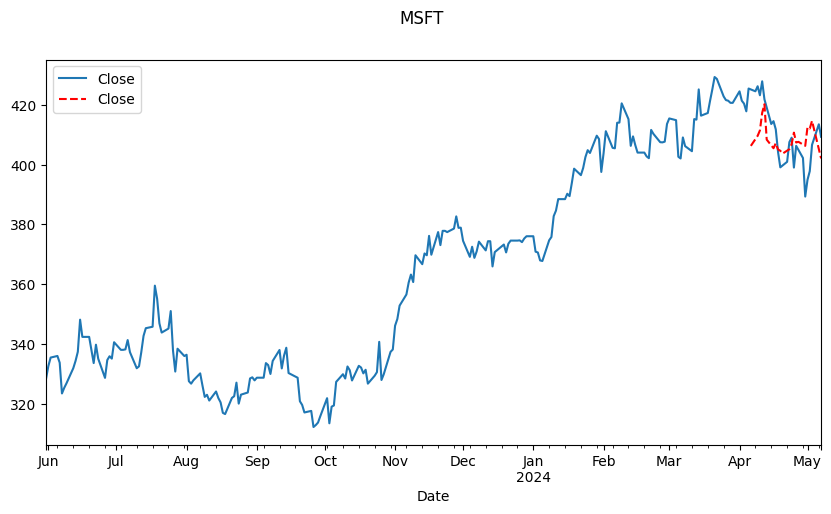

In [42]:
from typing import Any, List, Literal, Tuple, TypeAlias, cast
from dataclasses import dataclass
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from data import SCRAPED_STOCK_FILE_PATH
import logging
from gsp.model.utils import (
    get_minimal_stocks_existence_date,
    get_nth_previous_working_date,
    show,
)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import lightgbm as lgb

logger = logging.getLogger(__name__)

YEARS_BACK_TO_CONSIDER = 3
N_STEP_PREDICTION = 22

stocks =  pd.read_csv(
    SCRAPED_STOCK_FILE_PATH,
    dtype={
        "Date": "period[D]",
        "Open": "float",
        "High": "float",
        "Low": "float",
        "Close": "float",
        "Volume": "int",
        "Area": "category",
        "Name": "category",
    },
)

periods = pd.date_range(
    start=stocks["Date"].min().to_timestamp().date(), 
    end=stocks["Date"].max().to_timestamp().date(), 
    freq="B"
)
periods_df = pd.DataFrame({"Date": periods}, dtype="period[D]")
diff_periods = periods_df[~periods_df["Date"].isin(stocks["Date"])]
# show("Missing working holidays days: ",diff_periods)

cleaned = (cast(
    pd.DataFrame,
    periods_df.set_index("Date")
    .join(stocks.set_index("Date"))
    .set_index("Name", append=True)
    .sort_index()
    .unstack("Name")
    .ffill()
    .stack("Name", future_stack=True)) # type: ignore
    .reset_index()
    .dropna(subset=["Name"])
    .set_index(["Date", "Name"])
)


def make_shift_in_groups(
    df: pd.DataFrame,
    groupby: List[str] = [],
    column: str = "",
    shift: List[int] | int = 1,
    name: str | None = None,
) -> pd.DataFrame:
    df = df.copy(deep=True)
    if name is None:
        name = column

    if isinstance(shift, int):
        shift = [shift]

    shift = list(filter(lambda el: el != 0, shift))

    if len(shift) == 0:
        raise ValueError("Shift value must be non-zero!")

    def create_shifted_columns(group):
        shifted_group = pd.DataFrame(index=group.index)
        for val in shift:

            shifted_group[f"{name}_{'lead' if val < 0 else 'lag'}_{abs(val)}"] = group[column].shift(val)

        return shifted_group

    shifted_df = cast(
        pd.DataFrame,
        df.groupby(groupby, observed=True, group_keys=False)
        .apply(create_shifted_columns, include_groups=False)
        .sort_index(),
    )

    return shifted_df


MOVING_WINDOW_AGGREGATORS_ALIAS: TypeAlias = Literal["mean", "sum", "median", "std", "var"]


def make_mw_in_groups(
    df: pd.DataFrame,
    groupby: List[str] = [],
    column: str = "",
    window: List[int] | int = 30,
    center: List[bool] | bool = False,
    min_periods: List[int] | int = 1,
    aggregator: List[MOVING_WINDOW_AGGREGATORS_ALIAS] | MOVING_WINDOW_AGGREGATORS_ALIAS = "mean",
    name: str | None = None,
) -> pd.DataFrame:
    df = df.copy(deep=True)
    if name is None:
        name = column

    if isinstance(window, int):
        window = [window]

    window = list(filter(lambda x: x != 0, window))
    if len(window) == 0:
        raise ValueError("Window value must be non-zero!")
    if isinstance(center, bool):
        center = [center] * len(window)
    if isinstance(min_periods, int):
        min_periods = [min_periods] * len(window)
    if isinstance(aggregator, str):
        aggregator = cast(List[MOVING_WINDOW_AGGREGATORS_ALIAS], [aggregator]) * len(window)

    def create_mw_columns(group):
        ma_group = pd.DataFrame(index=group.index)
        for index, val in enumerate(window):
            type_name = "lag" if val > 0 else "lead"
            if val < 0:
                ma_group[f"{name}_{type_name}_{aggregator[index]}_{-val}"] = (
                    group[column]
                    .rolling(window=-val, center=center[index], min_periods=min_periods[index])
                    .aggregate(aggregator[index])
                    .shift(val)
                )
            else:
                ma_group[f"{name}_{type_name}_{aggregator[index]}_{val}"] = (
                    group[column]
                    .shift(1)
                    .rolling(window=val, center=center[index], min_periods=min_periods[index])
                    .aggregate(aggregator[index])
                )

        return ma_group

    return cast(
        pd.DataFrame,
        df.groupby(groupby, observed=True, group_keys=False)
        .apply(create_mw_columns, include_groups=False)
        .sort_index(),
    )


# categorical_features = ["DayOfWeek", "NameCat", "Month", "Year", "Quarter", "Area"]
categorical_features = ["DayOfWeek", "Year"]
stocks_pre_processed = cleaned.copy()

if "DayOfWeek" in categorical_features:
    stocks_pre_processed["DayOfWeek"] = stocks_pre_processed.index.get_level_values("Date").dayofweek

if "Month" in categorical_features:
    stocks_pre_processed["Month"] = stocks_pre_processed.index.get_level_values("Date").month

if "Year" in categorical_features:
    stocks_pre_processed["Year"] = stocks_pre_processed.index.get_level_values("Date").year

if "Quarter" in categorical_features:
    stocks_pre_processed["Quarter"] = stocks_pre_processed.index.get_level_values("Date").quarter

if "NameCat" in categorical_features:
    stocks_pre_processed["NameCat"] = stocks_pre_processed.index.get_level_values("Name").astype("category")

if not ("Area" in categorical_features):
    stocks_pre_processed = stocks_pre_processed.drop(columns=["Area"])

grouped_lags_list : List[pd.DataFrame | pd.Series] = [
    make_shift_in_groups(
        df=stocks_pre_processed,
        groupby=["Name"],
        column="Close",
        shift=[1]
    ),
    make_mw_in_groups(
        df=stocks_pre_processed,
        groupby=["Name"],
        column="Close",
        window=[5, 60],
        aggregator="mean"
    )
]


stocks_post_processed = stocks_pre_processed.join(grouped_lags_list)
# stocks_post_processed["GrowingMeanRate"] = stocks_post_processed["Close_lag_mean_5"] / stocks_post_processed["Close_lag_mean_60"]

most_recent_date = cast(datetime.date, stocks_pre_processed.index.get_level_values("Date").max().to_timestamp().date())
earliest_considerable_date = get_nth_previous_working_date(YEARS_BACK_TO_CONSIDER * 261, most_recent_date)
all_existence_date = get_minimal_stocks_existence_date(stocks)

least_recent_date = max(earliest_considerable_date, all_existence_date)

# show(
#     f"most_recent_date: {most_recent_date}",
#     f"earliest_considerable_date: {earliest_considerable_date}",
#     f"all_existence_date: {all_existence_date}",
#     f"least_recent_date: {least_recent_date}",
# )

# filter stocks_limited if you want to solve for single problem
stocks_limited = stocks_post_processed.loc[least_recent_date.isoformat() : most_recent_date.isoformat()]
stocks_limited = stocks_limited.loc[stocks_limited.index.get_level_values("Name").isin(["MSFT"])]
@dataclass
class ColumnTransformerWrapper:
    transformers: List[Tuple[str, Any, List[str]]]
    remainder: Literal["drop", "passthrough"] = "passthrough"

    def fit_transform(self, X: pd.DataFrame, y: Any | None = None) -> pd.DataFrame:  # type: ignore
        ct = ColumnTransformer(self.transformers, remainder=self.remainder)

        return pd.DataFrame(
            ct.fit_transform(X, y),  # type: ignore
            index=X.index,
            columns=[col.replace("remainder__", "") for col in ct.get_feature_names_out()],
        )


ctw = ColumnTransformerWrapper(
    transformers=[
        ("one_hot", OneHotEncoder(drop="first", sparse_output=False), categorical_features),
    ],
    remainder="passthrough",
)

X_encoded = ctw.fit_transform(stocks_limited)


X = X_encoded.drop(columns=["Adj Close", "Open", "High","Low", "Volume"])


y = make_shift_in_groups(df=stocks_limited, groupby=["Name"], column="Close",shift=[-i for i in range(1, N_STEP_PREDICTION+1)])

y, X = y.align(X.dropna(), axis=0, join="inner")
start_training_date = least_recent_date
end_training_date = get_nth_previous_working_date(n=3*N_STEP_PREDICTION, date=most_recent_date)
start_testing_date = get_nth_previous_working_date(n=-N_STEP_PREDICTION, date=end_training_date)
end_testing_date = get_nth_previous_working_date(n=N_STEP_PREDICTION, date=most_recent_date)


show(
    f"start_training_date: {start_training_date}",
    f"end_training_date: {end_training_date}",
    f"start_testing_date: {start_testing_date}",
    f"end_testing_date: {end_testing_date}",
)


X_train = X.loc[start_training_date.isoformat() : end_training_date.isoformat()]
y_train = y.loc[start_training_date.isoformat() : end_training_date.isoformat()]
X_test = X.loc[start_testing_date.isoformat() : end_testing_date.isoformat()]
y_test = y.loc[start_testing_date.isoformat() : end_testing_date.isoformat()]

show("FULL PROCESSED DATA")
show(X.columns)
show(y.columns)

show("TRAINING DATA")
show(X_train.columns)
show(y_train.columns)


hyper_params = {}

model = RegressorChain(XGBRegressor(**hyper_params))
# model = MultiOutputRegressor(XGBRegressor(**hyper_params))
# model = LinearRegression()
# model = RegressorChain(base_estimator=lgb.LGBMRegressor()) # type: ignore

logger.info("Training the model...")
show("TRAINING DATA X", X_train.tail(30))
show("TRAINING DATA y", y_train.tail(30))
model.fit(X_train, y_train)
logger.info("Model trained successfully")

y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns) # type: ignore

y_latest = y_pred.loc[y_pred.index.get_level_values("Date").max().to_timestamp().date().isoformat() :]


def convert_to_output(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(deep=True)
    last_date = df.index.get_level_values("Date").max().to_timestamp().date()

    df_renamed = df.rename(
        columns={
            f"Close_lead_{i}": get_nth_previous_working_date(n=-i, date=last_date)
            for i in range(1, N_STEP_PREDICTION + 1)
        }
    )
    df_melted = (
        df_renamed.reset_index("Name")
        .melt(id_vars=["Name"], var_name="Date", value_name="Close")
        .astype(
            {
                "Date": "period[D]",
                "Name": "category",
                "Close": "float",
            }
        )
        .set_index(["Date", "Name"])
    )

    return df_melted


y_output = y_latest.groupby("Name", observed=True, group_keys=False).apply(convert_to_output).sort_index()


show("PREDICTION", y_pred.tail(3))
show("TEST", y_test.tail(3))

stocks_ids = stocks_limited.index.get_level_values("Name").unique()

for stock_id in stocks_ids:
    fig = plt.figure(figsize=(10, 5))
    fig.suptitle(stock_id)
    stocks_limited.loc[
        (
            stocks_limited.index.get_level_values("Date")
            >= get_nth_previous_working_date(n=200, date=start_testing_date).isoformat()
        )
        & (stocks_limited.index.get_level_values("Name") == stock_id)
    ][["Close"]].reset_index("Name", drop=True).plot(ax=fig.gca(), legend=True)
    y_output.loc[y_output.index.get_level_values("Name") == stock_id][["Close"]].reset_index("Name", drop=True).plot(
        ax=fig.gca(), legend=True, style="--", color="red"
    )
    plt.show()